# 5I-IN7 : Projet mnist

On importe les fonctions dont on aura besoin pour le projet

In [1]:
import itertools

import numpy as np
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

On importe le jeu de données et on vérifie son intégrité

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

On convertit nos vecteurs en matrice.

In [3]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

On affiche quelques images de notre jeu de données

<generator object <genexpr> at 0x00000204874B4BA0>

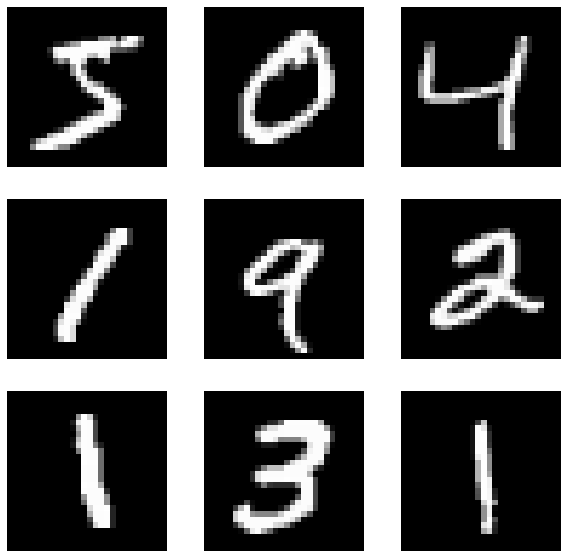

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
n = 0

for i in range(3):
    for j in range(3):
        image = np.array(x_train[n], dtype="float")
        axs[i, j].imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
        axs[i, j].axis("off")
        n += 1

(ax.label_outer() for ax in fig.get_axes())

On va normaliser nos images afin que le niveau de gris de celles-ci soient compris entre 0 et 1

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Ensuite on convertit nos images en nuance de gris

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

Création de notre model avec notre base convolutive

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

On entraine notre modèle

In [8]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 23s 8ms/step - loss: 0.3071 - accuracy: 0.9044 - val_loss: 0.0683 - val_accuracy: 0.9787
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0611 - accuracy: 0.9815 - val_loss: 0.0529 - val_accuracy: 0.9831
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0349 - accuracy: 0.9900 - val_loss: 0.0456 - val_accuracy: 0.9856
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0471 - val_accuracy: 0.9846
Epoch 5/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0404 - val_accuracy: 0.9868
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.0376 - val_accuracy: 0.9877
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 0.0415 - val_ac

On affiche l'évolution de l'entrainement de notre modèle

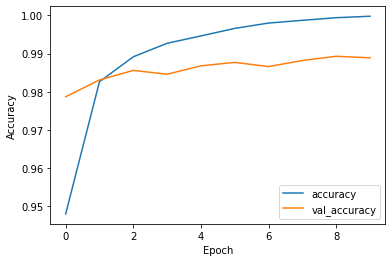

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

On teste notre modèle avec la base de test

In [10]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0374 - accuracy: 0.9889
Test accuracy: 0.9889000058174133


Notre modèle à une précision d'environ 98.7% sur la base de test

On affiche la matrice de confusion

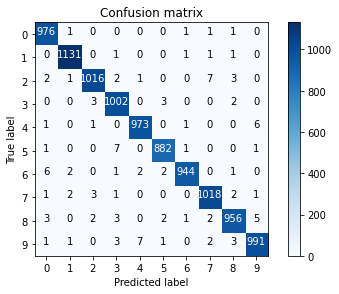

In [11]:

y_predict = model.predict(x_test)
y_predict_classes = np.argmax(y_predict, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_predict_classes)

classes = range(10)
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap("Blues"))
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En lisant cette matrice de confusion, on peut observer que notre modèle à quelques problèmes

Pour essayer de comprendre pourquoi notre modèle à des difficultés, on va afficher certaines de ces erreurs


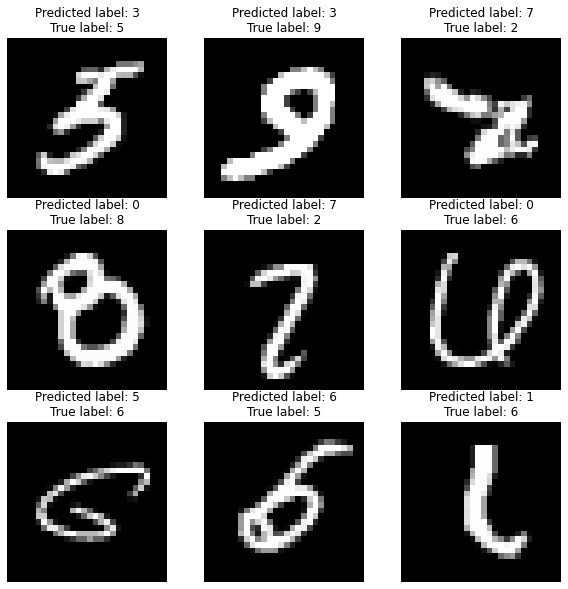

In [12]:
errors = (y_predict_classes - y_true != 0)

y_predict_classes_errors = y_predict_classes[errors]
y_predict_errors = y_predict[errors]
y_true_errors = y_true[errors]
x_values_errors = x_test[errors]

y_predict_errors_prob = np.max(y_predict_errors, axis=1)
true_prob_errors = np.diagonal(np.take(y_predict_errors, y_true_errors, axis=1))

most_important_errors = np.argsort(y_predict_errors_prob - true_prob_errors)[-9:]

n = 0
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        error = most_important_errors[n]
        axs[i, j].imshow((x_values_errors[error]).reshape((28, 28)), cmap=plt.get_cmap('gray'))
        axs[i, j].axis("off")
        axs[i, j].set_title("Predicted label: {}\nTrue label: {}".format(y_predict_classes_errors[error], y_true_errors[error]))
        n += 1

On peut voir que certaines des erreurs de notre modèle peuvent prêter à confusion.

Cependant, on peut voir que certaines erreurs pourraient être évitée en modifiant notre jeu de données et faire des rotations sur certaines images.